In [1]:
#https://colab.research.google.com/drive/1hownP4pc1_7kzF3NorXFd3A5fLguKlEh?authuser=4#scrollTo=generous-plumbing
#https://colab.research.google.com/drive/1hownP4pc1_7kzF3NorXFd3A5fLguKlEh
#1 preprocesing (resample to 128x128x32)! or other sizes or 48
#2 document stuff
#3 modify the diceloss!
#4 augmentation?
#5 same for AAA-DICOM?

In [1]:
#copy from github
!git clone https://github.com/kilgore92/PyTorch-UNet.git
%cd PyTorch-UNet
%cd src
from unet.model import UNet
%cd ..
%cd ..

fatal: destination path 'PyTorch-UNet' already exists and is not an empty directory.
/content/PyTorch-UNet
/content/PyTorch-UNet/src
/content/PyTorch-UNet
/content


In [2]:
#specify the model params
model_params = {}

#specify the type of model and its correspnding parameters
model_params = {
    'type': 'OG_Unet' #modify this to change the type and the later entries to change parameter settings
}

#aux params (classification)?
#aux_params = {
#    'classes': None,
#    'pooling': 'avg',
#    'dropout': 0,
#    'activation': None
#    }

#og_unet
if model_params['type'] == 'OG_Unet':
  model_params['n_channels'] = 1
  model_params['base_filter_num'] = 64
  model_params['num_blocks'] = 4
  model_params['num_classes'] = 1
  model_params['mode'] = '3D'
  model_params['dropout'] = False
  model_params['dropout_rate'] = 0.2
  model_params['use_pooling'] = True #dpes this make differnece?
  #define the model
  model = UNet(model_params['n_channels'], model_params['base_filter_num'], model_params['num_blocks'], model_params['num_classes'], model_params['mode'], model_params['dropout'],
               model_params['dropout_rate'], model_params['use_pooling'])

In [3]:
model.to('cuda')

UNet(
  (contracting_path): ModuleList(
    (0): EncoderBlock3D(
      (conv1): Conv3d(1, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
      (conv2): Conv3d(64, 128, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
      (bn_op_1): InstanceNorm3d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      (bn_op_2): InstanceNorm3d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    )
    (1): EncoderBlock3D(
      (conv1): Conv3d(128, 128, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
      (conv2): Conv3d(128, 256, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
      (bn_op_1): InstanceNorm3d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      (bn_op_2): InstanceNorm3d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    )
    (2): EncoderBlock3D(
      (conv1): Conv3d(256, 256, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
      

In [8]:
import torch
inputs = None
inputs = torch.rand((1, 1, 48, 208, 208)) #these dimensions work? 224 x 224 x 48

In [9]:


outputs = model(inputs.to('cuda'))


RuntimeError: ignored

In [11]:
128 + 64 + 16

208

In [14]:
216/12

18.0

In [ ]:
#mount drive
from google.colab import drive
drive.mount('/content/gdrive/', force_remount=True)

Mounted at /content/gdrive/


In [ ]:
#installations
!pip install --quiet torch==1.9 #this installation must be first; fixes GPU OOM Issue #1.9.0+cu102 #also reduces RAM usage
!pip install --quiet unet #https://github.com/fepegar/unet Nov 24, 2021
!pip install --quiet torchio #0.18.73
!pip install --quiet ctviewer
!pip install --quiet monai

     |████████████████████████████████| 831.4 MB 2.8 kB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchvision 0.13.1+cu113 requires torch==1.12.1, but you have torch 1.9.0 which is incompatible.
torchtext 0.13.1 requires torch==1.12.1, but you have torch 1.9.0 which is incompatible.
torchaudio 0.12.1+cu113 requires torch==1.12.1, but you have torch 1.9.0 which is incompatible.
     |████████████████████████████████| 172 kB 8.1 MB/s 
     |████████████████████████████████| 52.8 MB 1.5 MB/s 
     |████████████████████████████████| 990 kB 4.8 MB/s 


In [ ]:
#imports
import enum, time, random, multiprocessing, os
import pandas as pd
from pathlib import Path
import torch
try:
    assert(torch.cuda.is_available())
except:
    print("CUDA not available.")
#import torchvision
import torchio as tio
import torch.nn.functional as F
from unet import UNet
import numpy as np
import scipy
from scipy import stats
import matplotlib.pyplot as plt
from IPython import display
from tqdm.notebook import tqdm
import SimpleITK as sitk
import glob
import datetime
from datetime import datetime
from ctviewer import CTViewer
import shutil
import torch.nn as nn
import random
import json
import monai
from monai.losses import GeneralizedDiceLoss
seed = 42
random.seed(seed)
torch.manual_seed(seed)
%config InlineBackend.figure_format = 'png'
num_workers = 1
#torch version 1.9.0+cu102
print('Torch version:', torch.__version__)
print('TorchIO version:', tio.__version__) #0.18.20
#device
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(device)

/usr/local/lib/python3.7/dist-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: libtorch_cuda_cu.so: cannot open shared object file: No such file or directory
  warn(f"Failed to load image Python extension: {e}")


Torch version: 1.9.0+cu102
TorchIO version: 0.18.84
cuda


In [ ]:
#save json file
def save_params(hyper_params, save_path):
  json_string = json.dumps(hyper_params)
  with open(save_path, 'w') as outfile:
    outfile.write(json_string)

#specify the DiceLoss
class DICELoss(nn.Module):
      def __init__(self, weight=None, size_average=True):
          super(DICELoss, self).__init__()

      def forward(self, output, mask, eps=1e-8):
          """
          The output layer of Kilgore's 3D-UNet implementation is a LeakyReLU.
          We need to apply a sigmoid activation to the model output in order to
          constrain the target value between 0 and 1.
          See source code (Line 243):
          https://github.com/kilgore92/PyTorch-UNet/blob/master/src/unet/blocks.py#L243
          """

          output = torch.sigmoid(output)
          
          output = output.view(-1)
          mask = mask.view(-1)
          
          intersection = (output * mask).sum()                            
          dice_coeff = (2.*intersection + eps)/(output.sum() + mask.sum() + eps)  

          dice_loss = 1 - dice_coeff

          return dice_loss

#init parameters
#CHANNELS_DIMENSION = train_params['CHANNELS_DIMENSION']
#SPATIAL_DIMENSIONS = train_params['SPATIAL_DIMENSIONS']

#Action
class Action(enum.Enum):
    TRAIN = 'Training'
    VALIDATE = 'Validation'

#prepare te batch
def prepare_batch(batch, device):
    inputs = batch['image'][tio.DATA].to(device)
    targets = batch['segmentation'][tio.DATA].to(device)
    return inputs, targets

#dic score (not used later)
#def get_dice_score(output, target, epsilon=1e-9):
#    p0 = output
#    g0 = target
#    p1 = 1 - p0
#    g1 = 1 - g0
#    tp = (p0 * g0).sum(dim=SPATIAL_DIMENSIONS)
#    fp = (p0 * g1).sum(dim=SPATIAL_DIMENSIONS)
#    fn = (p1 * g0).sum(dim=SPATIAL_DIMENSIONS)
#    num = 2 * tp
#    denom = 2 * tp + fp + fn + epsilon
#    dice_score = num / denom
#    return dice_score

#dice loss (not used later)
#def get_dice_loss(output, target):
#    return 1 - get_dice_score(output, target)

#get model and optimizer (AdamW) can also specy pretrained weights
def get_model_and_optimizer(train_params, device, model_weights = None):
    model = UNet(
        in_channels = train_params['model_params']['in_channels'],
        out_classes = train_params['model_params']['out_classes'],
        dimensions = train_params['model_params']['dimensions'],
        num_encoding_blocks = train_params['model_params']['num_encoding_blocks'],
        out_channels_first_layer = train_params['model_params']['out_channels_first_layer'],
        normalization = train_params['model_params']['normalization'],
        upsampling_type = train_params['model_params']['upsampling'],
        residual = train_params['model_params']['residual'],
        activation = train_params['model_params']['activation'],
        padding = train_params['model_params']['padding']
        ).to(device)
    #if weights are none
    if model_weights is not None:
        checkpoint = torch.load(model_weights)
        model.load_state_dict(checkpoint)
    #optimizer
    optimizer = torch.optim.AdamW(model.parameters(), lr=train_params['lr'])
    #return
    return model, optimizer

#run a single epoch
def run_epoch(epoch_idx, action, loader, model, optimizer):
    is_training = action == Action.TRAIN
    epoch_losses = []
    times = []
    model.train(is_training)
    for batch_idx, batch in enumerate(tqdm(loader)):
        inputs, targets = prepare_batch(batch, device)
        optimizer.zero_grad()
        with torch.set_grad_enabled(is_training):
            logits = model(inputs)
            #the loss function was changed from multiclass (softmax) to binary dice
            batch_loss = criterion(logits, targets)
            #batch_loss = criterion(logits, targets)
            if is_training:
                batch_loss.backward()
                optimizer.step()
            times.append(time.time())
            epoch_losses.append(batch_loss.item())
    epoch_losses = np.array(epoch_losses)
    print(f'{action.value} mean loss: {epoch_losses.mean():0.3f}')
    return times, epoch_losses

#for a single epoch
def train(num_epochs, training_loader, validation_loader, model, optimizer, weights_stem):

    with open(os.path.join(model_dir,f'{weights_stem}_training_log_{num_epochs}_epochs.csv'),'a+') as fd:
        fd.write('time,epoch,train_loss,val_loss\n')

    try: num_epochs_trained = model.num_epochs_trained
    except: num_epochs_trained = 0
    
    train_losses = []
    val_losses = []
    
    # Get a baseline loss on the validation set before training
    if num_epochs_trained == 0:
        val_losses.append(run_epoch(0, Action.VALIDATE, validation_loader, model, optimizer))

    for epoch_idx in range(1 + num_epochs_trained, num_epochs + 1):
        print('Starting epoch', epoch_idx)
        train_losses.append(run_epoch(epoch_idx, Action.TRAIN, training_loader, model, optimizer))
        val_losses.append(run_epoch(epoch_idx, Action.VALIDATE, validation_loader, model, optimizer))
        torch.save(model.state_dict(), os.path.join(model_dir,f'{weights_stem}_epoch_{epoch_idx}.pth'))

        with open(os.path.join(model_dir,f'{weights_stem}_training_log.csv'),'a+') as fd:
            mean_train = np.array(train_losses[-1])[1].mean()
            mean_val = np.array(val_losses[-1])[1].mean()
            fd.write(f'{time.time()},{epoch_idx},{mean_train},{mean_val}\n')

        with open(os.path.join(model_dir,f'{weights_stem}_training_log_{num_epochs}_epochs.csv'),'a+') as fd:
            fd.write(f'{time.time()},{epoch_idx},{mean_train},{mean_val}\n')

        #save the train params file after every epoch
        train_params['epochs_trained'] = epoch_idx
        save_params(train_params, train_params['save_path']+ 'train_params.json')

    return np.array(train_losses), np.array(val_losses)

#visualize one specific image (cannot superimpose mask as of yet)
def visualize_specific_image(row, im_type):
  image = sitk.GetArrayFromImage(sitk.ReadImage(row[im_type]))
  CTViewer(image)
  plt.show()

#image resampling
def resample_image_standardize(itk_image, out_size = (128,128,64), is_label = False):
  original_spacing = itk_image.GetSpacing()
  original_size = itk_image.GetSize()
  out_spacing = [original_size[0] * (original_spacing[0] / out_size[0]),
                 original_size[1] * (original_spacing[1] / out_size[1]),
                 original_size[2] * (original_spacing[2] / out_size[2])]

  resample = sitk.ResampleImageFilter()
  resample.SetOutputSpacing(out_spacing)
  resample.SetOutputOrigin(itk_image.GetOrigin())
  resample.SetSize(out_size)
  resample.SetOutputDirection(itk_image.GetDirection())
  resample.SetTransform(sitk.Transform())
  #resample.SetDefaultPixelValue(itk_image.GetPixelIDValue())
  if is_label:
      resample.SetInterpolator(sitk.sitkNearestNeighbor)
  else:
      resample.SetInterpolator(sitk.sitkBSpline)
  return resample.Execute(itk_image)

def resample(image_paths, save_path, label):
  #init
  z = sitk.NormalizeImageFilter()
  if os.path.isdir(save_path) == False:
    os.mkdir(save_path)
  #iterate
  for image_path in image_paths:
    image = sitk.ReadImage(image_path)
    image = resample_image_standardize(image, is_label = label)
    patient = image_path.rpartition('/')[2]
    if label == False:
      image = z.Execute(image)
      new_image = sitk.Cast(image, sitk.sitkFloat32) #very important that this is Float32/Float64 will not work --> Double
      new_image.CopyInformation(image)
    else:
      new_image = image
    sitk.WriteImage(new_image, save_path + patient)
    #sitkFloat32

In [ ]:
#read in the saved pickle file
data_path = '/content/gdrive/MyDrive/AAA_Project/Masters-Thesis/AAA-Wall/data/3D/data_filter_status_split.pkl'
df = pd.read_pickle(data_path)

In [ ]:
#save folder
save_folder = '/content/' #'/content/gdrive/MyDrive/AAA_Project/Masters-Thesis/AAA-Wall/results/3D-TorchIO-AAA-UNet-results/'
#specify a save location
folder = datetime.now().strftime("torchio-%Y-%m-%d-%H-%M") + '/'
#the save path for everything
save_path = save_folder + folder
if os.path.isdir(save_path) == False:
  os.mkdir(save_path)

In [ ]:
#model
model_params = {
    'type': 'UNet',
    'in_channels': 1,
    'out_classes': 2,
    'dimensions': 3,
    'num_encoding_blocks': 4,
    'out_channels_first_layer': 32,
    'normalization': 'batch',
    'upsampling': 'linear',
    'residual': True,
    'activation': 'PReLU',
    'padding': True
}
#training parameters
train_params = {
    'batch_size': 4,
    'lr': 1e-5, #increase or decrease?
    'optimizer': 'AdamW',
    'weight_decay': 1e-1,
    'epochs': 20,
    'loss': 'GenDiceLoss',
    'aug': True,
    'save_path': save_path, 
    'epochs_trained': 0,
    'model_type': 'patch',
    #'CHANNELS_DIMENSION': 1, #not used
    #'SPATIAL_DIMENSIONS': 1, #not used
    'patch_size': 64, #1
    'samples_per_volume': 4, #500
    'max_queue_length': 1000, #1000
    'model_params': model_params,
    'col_image': 'Norm-CTA-Cropped-128-128-64',
    'col_label': 'Mask-Cropped-Wall-128-128-64',
    'data_path': data_path
}

In [ ]:
#used cropped dataset? native resolution?

# Obtain the training images and labels
train_image_paths = df[df['DATA'] == 'TRAIN'][train_params['col_image']].to_list()
train_label_paths = df[df['DATA'] == 'TRAIN'][train_params['col_label']].to_list()

# Obtain the test images and labels
test_image_paths = df[df['DATA'] == 'TEST'][train_params['col_image']].to_list()
test_label_paths = df[df['DATA'] == 'TEST'][train_params['col_label']].to_list()

In [ ]:
%%time
#resample(train_image_paths, '/content/train_image_paths/', label = False)
#resample(test_image_paths, '/content/test_image_paths/', label = False)
#resample(train_label_paths, '/content/train_label_paths/', label = True)
#resample(test_label_paths, '/content/test_label_paths/', label = True)
#reget the paths
#train_image_paths = sorted(glob.glob('/content/train_image_paths/*.nii.gz'))[0:2]
#train_label_paths = sorted(glob.glob('/content/train_label_paths/*.nii.gz'))[0:2]
#test_image_paths = sorted(glob.glob('/content/test_image_paths/*.nii.gz'))[0:2]
#test_label_paths = sorted(glob.glob('/content/test_label_paths/*.nii.gz'))[0:2]

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.91 µs


Dataset size: 36 subjects
Dataset size: 30 subjects


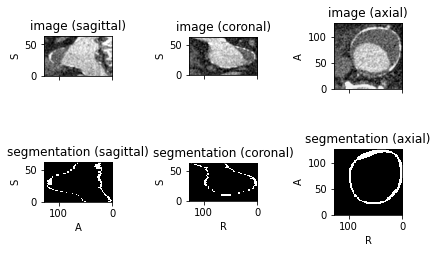

Subject(Keys: ('image', 'segmentation', 'name'); images: 2)
ScalarImage(shape: (1, 128, 128, 64); spacing: (0.56, 0.53, 0.62); orientation: LPS+; dtype: torch.FloatTensor; memory: 4.0 MiB)
LabelMap(shape: (1, 128, 128, 64); spacing: (0.56, 0.53, 0.62); orientation: LPS+; dtype: torch.ByteTensor; memory: 1.0 MiB)
Training Set: 36 subjects
Validation Set: 30 subjects


In [ ]:
#need to specify the paths for setting up the data loader
#train_image_paths/train_label_paths
#test_image_paths/test_label_paths

# Create the training set Dataloader
train_subjects = []
for i, (image_path, label_path) in enumerate(list(zip(train_image_paths, train_label_paths))):
    subject = tio.Subject(
        image=tio.ScalarImage(image_path),
        segmentation=tio.LabelMap(label_path),
        name=[label_path, image_path]
    )
    train_subjects.append(subject)

# Create the testing set Dataloader
test_subjects = []
for i, (image_path, label_path) in enumerate(list(zip(test_image_paths, test_label_paths))):
    subject = tio.Subject(
        image=tio.ScalarImage(image_path),
        segmentation=tio.LabelMap(label_path),
        name=[label_path, image_path]
    )
    test_subjects.append(subject)

  # View length of train and test datasets
train_dataset = tio.SubjectsDataset(train_subjects)
print('Dataset size:', len(train_dataset), 'subjects')

test_dataset = tio.SubjectsDataset(test_subjects)
print('Dataset size:', len(test_dataset), 'subjects')

#single subject
one_subject = test_dataset[1]
one_subject.plot()
#print
print(one_subject)
print(one_subject.image)
print(one_subject.segmentation)

#augmentation
training_transform = tio.Compose([
    #spatial
    tio.RandomFlip(axes = (0, 1, 2), flip_probability = 0.5),
    tio.RandomNoise(mean = [-0.9, 0.9], std = [0.01, 0.1]),
    tio.RandomAffine(scales = [0.9, 1.1], degrees = random.choice([30, 60, 90, 120, 150, 180, 210, 240, 270, 300, 330])),
    # tio.ToCanonical(),
    # tio.HistogramStandardization({'image': landmarks}),
    #tio.ZNormalization(masking_method=tio.ZNormalization.mean), #unnecceasry does prior
    # tio.RandomNoise(),
    # tio.RandomFlip(),
    #tio.OneHot(),
]) #may want to increase augmentation here

#seperate
training_subjects, validation_subjects = train_dataset, test_dataset
#augmentation
training_set = tio.SubjectsDataset(training_subjects, transform=training_transform)
#no augmentation
validation_set = tio.SubjectsDataset(validation_subjects)
#print
print('Training Set:', len(training_set), 'subjects')
print('Validation Set:', len(validation_set), 'subjects')

#specify the training parameters
training_batch_size = train_params['batch_size']
validation_batch_size = train_params['batch_size']
patch_size = train_params['patch_size']
samples_per_volume = train_params['samples_per_volume'] #500
max_queue_length = train_params['max_queue_length']
#sampler = tio.data.UniformSampler(patch_size)
sampler = tio.data.GridSampler(training_subjects[0], patch_size)
#specify the patching strategy for the training set
patches_training_set = tio.Queue(
    subjects_dataset=training_set,
    max_length=max_queue_length,
    samples_per_volume=samples_per_volume,
    sampler=sampler,
    num_workers=num_workers,
    shuffle_subjects=True,
    shuffle_patches=True,
)
#specify the patching strategy for the testing set
patches_validation_set = tio.Queue(
    subjects_dataset=validation_set,
    max_length=max_queue_length,
    samples_per_volume=samples_per_volume,
    sampler=sampler, #this should always be Gridsamler? #https://torchio.readthedocs.io/patches/patch_training.html#
    num_workers=num_workers,
    shuffle_subjects=False,
    shuffle_patches=False,
)
#load training data
training_loader_patches = torch.utils.data.DataLoader(
    patches_training_set, batch_size=training_batch_size)
#load testig data
validation_loader_patches = torch.utils.data.DataLoader(
    patches_validation_set, batch_size=validation_batch_size)

In [ ]:
#directory to save model files
model_dir = train_params['save_path']
#dice loss
#criterion = DICELoss()
criterion = GeneralizedDiceLoss(include_background = True, softmax = True, to_onehot_y = True)
#try resume
try_resume = False
#the epochs to train for
num_epochs = train_params['epochs']
#checkpointed epochs
try_resume_epoch = train_params['epochs_trained'] #need to check this! / haven't tested for 
#loading pretrained then coninue training functionality

  0%|          | 0/30 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:575: UserWarning: floor_divide is deprecated, and will be removed in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values.
To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor'). (Triggered internally at  /pytorch/aten/src/ATen/native/BinaryOps.cpp:467.)
  return torch.floor_divide(self, other)


Validation mean loss: 0.888
Starting epoch 1


  0%|          | 0/36 [00:00<?, ?it/s]

Training mean loss: 0.857


  0%|          | 0/30 [00:00<?, ?it/s]

Validation mean loss: 0.870
Starting epoch 2


  0%|          | 0/36 [00:00<?, ?it/s]

Training mean loss: 0.865


  0%|          | 0/30 [00:00<?, ?it/s]

Validation mean loss: 0.879
Starting epoch 3


  0%|          | 0/36 [00:00<?, ?it/s]

Training mean loss: 0.857


  0%|          | 0/30 [00:00<?, ?it/s]

Validation mean loss: 0.868
Starting epoch 4


  0%|          | 0/36 [00:00<?, ?it/s]

Training mean loss: 0.843


  0%|          | 0/30 [00:00<?, ?it/s]

Validation mean loss: 0.875
Starting epoch 5


  0%|          | 0/36 [00:00<?, ?it/s]

Training mean loss: 0.846


  0%|          | 0/30 [00:00<?, ?it/s]

Validation mean loss: 0.857
Starting epoch 6


  0%|          | 0/36 [00:00<?, ?it/s]

Training mean loss: 0.843


  0%|          | 0/30 [00:00<?, ?it/s]

Validation mean loss: 0.851
Starting epoch 7


  0%|          | 0/36 [00:00<?, ?it/s]

Training mean loss: 0.793


  0%|          | 0/30 [00:00<?, ?it/s]

Validation mean loss: 0.764
Starting epoch 8


  0%|          | 0/36 [00:00<?, ?it/s]

Training mean loss: 0.762


  0%|          | 0/30 [00:00<?, ?it/s]

Validation mean loss: 0.745
Starting epoch 9


  0%|          | 0/36 [00:00<?, ?it/s]

Training mean loss: 0.773


  0%|          | 0/30 [00:00<?, ?it/s]

Validation mean loss: 0.748
Starting epoch 10


  0%|          | 0/36 [00:00<?, ?it/s]

Training mean loss: 0.768


  0%|          | 0/30 [00:00<?, ?it/s]

Validation mean loss: 0.755
Starting epoch 11


  0%|          | 0/36 [00:00<?, ?it/s]

Training mean loss: 0.768


  0%|          | 0/30 [00:00<?, ?it/s]

Validation mean loss: 0.729
Starting epoch 12


  0%|          | 0/36 [00:00<?, ?it/s]

Training mean loss: 0.747


  0%|          | 0/30 [00:00<?, ?it/s]

Validation mean loss: 0.723
Starting epoch 13


  0%|          | 0/36 [00:00<?, ?it/s]

Training mean loss: 0.733


  0%|          | 0/30 [00:00<?, ?it/s]

Validation mean loss: 0.722
Starting epoch 14


  0%|          | 0/36 [00:00<?, ?it/s]

Training mean loss: 0.741


  0%|          | 0/30 [00:00<?, ?it/s]

Validation mean loss: 0.791
Starting epoch 15


  0%|          | 0/36 [00:00<?, ?it/s]

Training mean loss: 0.747


  0%|          | 0/30 [00:00<?, ?it/s]

Validation mean loss: 0.758
Starting epoch 16


  0%|          | 0/36 [00:00<?, ?it/s]

Training mean loss: 0.740


  0%|          | 0/30 [00:00<?, ?it/s]

Validation mean loss: 0.710
Starting epoch 17


  0%|          | 0/36 [00:00<?, ?it/s]

Training mean loss: 0.745


  0%|          | 0/30 [00:00<?, ?it/s]

Validation mean loss: 0.728
Starting epoch 18


  0%|          | 0/36 [00:00<?, ?it/s]

Training mean loss: 0.726


  0%|          | 0/30 [00:00<?, ?it/s]

Validation mean loss: 0.718
Starting epoch 19


  0%|          | 0/36 [00:00<?, ?it/s]

Training mean loss: 0.742


  0%|          | 0/30 [00:00<?, ?it/s]

Validation mean loss: 0.696
Starting epoch 20


  0%|          | 0/36 [00:00<?, ?it/s]

Training mean loss: 0.733


  0%|          | 0/30 [00:00<?, ?it/s]

Validation mean loss: 0.701


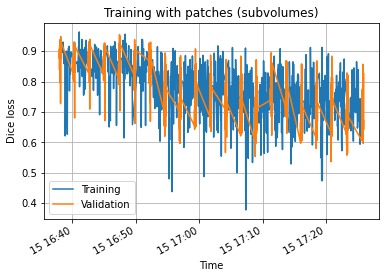

In [ ]:
#specify the training
if try_resume:
    # resume_model_weights = f'./checkpoints/patches_epoch_{try_resume_epoch-1}.pth'
    resume_model_weights = os.path.join(model_dir,f'patches_epoch_{try_resume_epoch-1}.pth')
    model, optimizer = get_model_and_optimizer(train_params, device, model_weights=resume_model_weights)
    model.num_epochs_trained = try_resume_epoch-1
else:
    model, optimizer = get_model_and_optimizer(train_params, device)
    model.num_epochs_trained = 0

weights_path = os.path.join(model_dir,f'{num_epochs}_epochs_patches_state_dict.pth')
weights_stem = 'patches'

try: os.mkdir('checkpoints')
except: pass

#train()
train_losses, val_losses = train(
    num_epochs,
    training_loader_patches,
    validation_loader_patches,
    model,
    optimizer,
    weights_stem,
)

#loads the best model when training has completed
loss_df = pd.read_csv(os.path.join(model_dir,f'{weights_stem}_training_log_{num_epochs}_epochs.csv'))
best_epoch = int(loss_df.iloc[loss_df['train_loss'].idxmin()]['epoch'])
epoch_paths = pd.Series(sorted(glob.glob(os.path.join(model_dir,"*.pth"))))
best_path = epoch_paths[epoch_paths.str.count(f'_{best_epoch}.pth') > 0]
best_path.reset_index(inplace=True, drop=True)
bestpoint = torch.load(best_path[0])
model, optimizer = get_model_and_optimizer(train_params, device)
model.load_state_dict(bestpoint)

#for the best?
checkpoint = {
    'train_losses': train_losses,
    'val_losses': val_losses,
    'weights': model.state_dict(),
}

torch.save(checkpoint, weights_path)

with open(os.path.join(model_dir,f'saved_epochs.csv'),'a+') as fd:
  fd.write(f'Epoch saved from {weights_stem}_training_log_{num_epochs}_epochs.csv: {best_epoch}\n')

def plot_times(axis, losses, label):
    from datetime import datetime
    times, losses = losses.transpose(1, 0, 2)
    times = [datetime.fromtimestamp(x) for x in times.flatten()]
    axis.plot(times, losses.flatten(), label=label)

# Loss curve for resuming training not implemented yet
if not try_resume:
    fig, ax = plt.subplots()
    plot_times(ax, train_losses, 'Training')
    plot_times(ax, val_losses, 'Validation')
    ax.grid()
    ax.set_xlabel('Time')
    ax.set_ylabel('Dice loss')
    ax.set_title('Training with patches (subvolumes)')
    ax.legend()
    fig.autofmt_xdate()
else:
    fig, ax = plt.subplots()
    plot_times(ax, train_losses, 'Training')
    plot_times(ax, val_losses, 'Validation')
    ax.grid()
    ax.set_xlabel('Time')
    ax.set_ylabel('Dice loss')
    ax.set_title('Training with patches (subvolumes)')
    ax.legend()
    fig.autofmt_xdate()

In [ ]:
x = validation_set.__getitem__(5)

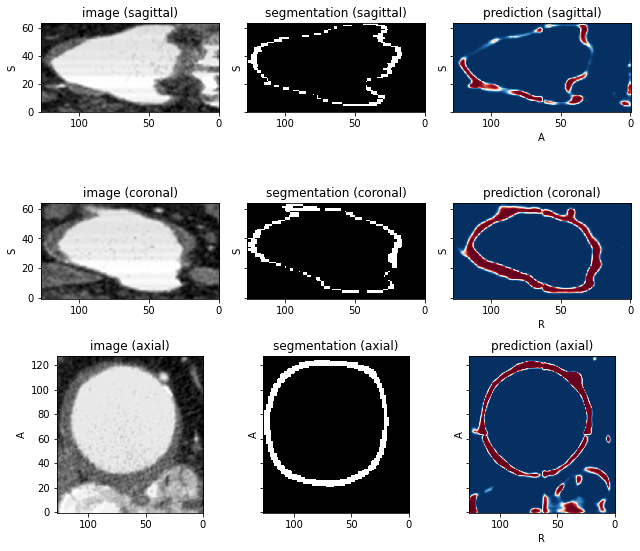

In [ ]:
row = df[df['DATA'] == 'TEST'].iloc[4]
image_path = row[train_params['col_image']]
label_path = row[train_params['col_label']]
CHANNELS_DIMENSION = 1
patch_overlap = 0
#perform inference for a single subject
subject = tio.SubjectsDataset([tio.Subject(image = tio.ScalarImage(image_path), segmentation = tio.LabelMap(label_path),)])
subject = subject[0]
#subject = tio.SubjectsDataset([tio.Subject(image = tio.ScalarImage(image_path),)])
#grid sampler
grid_sampler = tio.inference.GridSampler(subject, patch_size, patch_overlap,)
#patch loader
patch_loader = torch.utils.data.DataLoader(grid_sampler, batch_size=validation_batch_size)
#aggregate
aggregator = tio.inference.GridAggregator(grid_sampler)
#the model
model.eval()
#no grad
with torch.no_grad():
  #iterate
  for patches_batch in patch_loader:
    #inputs
    inputs = patches_batch['image'][tio.DATA].to(device)
    #locations
    locations = patches_batch[tio.LOCATION]
    #prob
    probabilities = model(inputs).softmax(dim=CHANNELS_DIMENSION)
    #append
    aggregator.add_batch(probabilities, locations)

#foreground
foreground = aggregator.get_output_tensor()
#affine
affine = subject.image.affine
#get the final prediction
prediction = tio.ScalarImage(tensor=foreground, affine=affine)
#visual
subject.add_image(prediction, 'prediction')
subject.plot(figsize=(9, 8), cmap_dict={'prediction': 'RdBu_r'})

In [ ]:
#gets outer wall of the lumen instead of the AAA

In [ ]:
f

In [ ]:
f['prediction']

TypeError: ignored

In [ ]:
subject[0]

Subject(Keys: ('image', 'segmentation'); images: 2)

In [ ]:
plt.imshow(prediction)

In [ ]:
CTViewer(prediction.numpy()[1])

interactive(children=(RadioButtons(description='Slice plane selection:', index=2, options=('y-z', 'z-x', 'x-y'…

In [ ]:
!cp -r /content/torchio-2022-09-15-16-35/train_params.json /content/gdrive/MyDrive/AAA_Project/Masters-Thesis/AAA-Wall/patch-segmentation/

In [ ]:
image = tio.ScalarImage('t1.npy', reader=prediction)

FileNotFoundError: ignored

In [ ]:
#inference on one image
subject = tio.SubjectsDataset([tio.Subject(
            image=tio.ScalarImage(image_path),
            segmentation=tio.LabelMap(label_path),
        )], transform=validation_transform)[0]

    grid_sampler = tio.inference.GridSampler(
        subject,
        patch_size,
        patch_overlap,
    )
    
    patch_loader = torch.utils.data.DataLoader(
        grid_sampler, batch_size=validation_batch_size)
    aggregator = tio.inference.GridAggregator(grid_sampler)

    model.eval()
    with torch.no_grad():
        for patches_batch in patch_loader:
            inputs = patches_batch['image'][tio.DATA].to(device)
            locations = patches_batch[tio.LOCATION]
            probabilities = model(inputs).softmax(dim=CHANNELS_DIMENSION)
            aggregator.add_batch(probabilities, locations)

    foreground = aggregator.get_output_tensor()
    affine = subject.image.affine
    prediction = tio.ScalarImage(tensor=foreground, affine=affine)
    subject.add_image(prediction, 'prediction')
    subject.plot(figsize=(9, 8), cmap_dict={'prediction': 'RdBu_r'})

In [ ]:
#load the model and then load in the pretrained weights


In [ ]:
subject = tio.SubjectsDataset([tio.Subject(
            image=tio.ScalarImage(image_path),
            segmentation=tio.LabelMap(label_path),
        )])[0]


In [ ]:
#load in the model
#https://torchio.readthedocs.io/patches/patch_training.html#

In [ ]:
#specify the inference strategy (note this training process svaes the checkpoints as opposed to the entire model) 
#and then operate on each row; reverting to original image volume as before
model.load_state_dict(torch.load('/content/torchio-2022-09-14-14-37/patches_epoch_10.pth'))
#operate on each row
inputs = torch.Tensor(np.expand_dims(sitk.GetArrayFromImage(sitk.ReadImage('/content/test_image_paths/GU003.nii.gz')), axis = (0, 1)))
outputs = model(inputs.to(device))
outputs.shape
arr = np.squeeze(torch.sigmoid(outputs).cpu().detach().numpy())

In [ ]:
arr.shape

(64, 128, 128)

In [ ]:
sitk.WriteImage(sitk.GetImageFromArray(arr), 'temp.nii.gz')